# Model 100 basicSt

Charlie Shobe, borrowing heavily from Greg Tucker's notes.

This notebook is a test of stream power driven by stochastic hydrology.

Fluvial erosion in this model is described by:
$$ E = F_w K_q r^{1/2} A^{1/2} S$$,

where $r = p - I_c (1 - \exp ( -p / I_c ))$, $p$ is the precipitation rate, $F_w$ is the fraction of wet days, $K_q$ is an erosion coefficient, and $I_c$ is inflitration capacity.

This model includes hillslope sediment transport by linear diffusion, but I will turn that off by setting $D=10^{-20}$.

We can see from the above that $K'=K_q(p - I_c (1 - \exp ( -p / I_c )))^m$, where $K'$ omits the factor $F_w$. This whole situation isn't great because $K$ is a function of precipitation rate. To compare this model to an analytical slope-area solution, we need to get a long-term average $K$, which we can do by integrating $K(p)$ over the full probability distribution (Weibull) of $p$:

$$ f(p) = \frac{c}{\lambda}\left( \frac{p}{\lambda} \right)^{(c-1)} e^{-(p/\lambda)^c} $$

to yield an effective $K$:

$$ K = F_w \int_{I_c}^\infty K'(p) f(p) dp  $$

$$ K = F_w \int_{I_c}^\infty K_q (p - I_c (1 - \exp ( -p / I_c )))^m \frac{c}{\lambda}\left( \frac{p}{\lambda} \right)^{(c-1)} e^{-(p/\lambda)^c} dp $$

This must be integrated numerically.

In [1]:
from erosion_model import BasicSt
import numpy as np
import matplotlib.pyplot as plt
from landlab import imshow_grid
import scipy.special as sp

//anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
#parameter dictionary 
params = { 'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_stochastic_sp' : 0.005,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 10e-20,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output',
          'opt_stochastic_duration': False,
          'mean_storm__intensity' : 3.0,
          'intermittency_factor' : .5,
          'infiltration_capacity' : 10,
          'number_of_sub_time_steps' : 10,
          'precip_shape_factor' : 0.7,
          'random_seed' : 1234567
}

In [3]:
#instantiate and establish topo error tolerance
st = BasicSt(params=params)
tolerance = 0.001

In [4]:
#time loop
dt = 10
elapsed_time = 0 #years
keep_running = True
while keep_running == True:
    pre_topo = st.grid.at_node['topographic__elevation'][st.grid.core_nodes]
    st.run_one_step(dt)
    post_topo = st.grid.at_node['topographic__elevation'][st.grid.core_nodes]
    if elapsed_time % 1000 == 0:
        print elapsed_time
        print 'MAX: ', max(abs(pre_topo - post_topo))
        print 'MEAN: ', np.average(abs(pre_topo - post_topo))
    elapsed_time += dt
    if max(abs(pre_topo - post_topo)) <= tolerance: #1mm
        keep_running = False

0
MAX:  0.123323353801
MEAN:  0.00404187534072
1000
MAX:  0.005
MEAN:  0.00412038140933
2000
MAX:  0.0151030822065
MEAN:  0.0023152701862
3000
MAX:  0.0124949199702
MEAN:  0.00194637799097
4000
MAX:  0.0149826558696
MEAN:  0.00192707532465
5000
MAX:  0.0204914240874
MEAN:  0.00153772431707
6000
MAX:  0.0166216325801
MEAN:  0.00186881951545
7000
MAX:  0.00400290073697
MEAN:  0.00167834216336
8000
MAX:  0.0174985684053
MEAN:  0.00291143748793
9000
MAX:  0.0103446895502
MEAN:  0.000869845511282
10000
MAX:  0.00447524202747
MEAN:  0.00312379090155
11000
MAX:  0.00442777353181
MEAN:  0.00294280781076
12000
MAX:  0.00444588489975
MEAN:  0.00168768819508
13000
MAX:  0.0128151812921
MEAN:  0.00146890973874
14000
MAX:  0.00390961041132
MEAN:  0.0019583623077
15000
MAX:  0.00777729906023
MEAN:  0.000692809247455
16000
MAX:  0.00396114722846
MEAN:  0.00208898942707
17000
MAX:  0.00659914693166
MEAN:  0.000764361817925
18000
MAX:  0.0110054389794
MEAN:  0.00256026342288
19000
MAX:  0.0089981591686

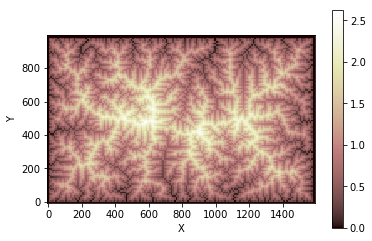

In [5]:
%matplotlib inline
imshow_grid(st.grid, 'topographic__elevation')

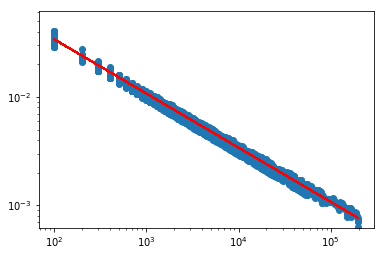

In [6]:
#first: the data
plt.scatter(st.grid.at_node['drainage_area'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)], st.grid.at_node['topographic__steepest_slope'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)])

#second: the detachment-limited slope-area relationship
plt.plot(st.grid.at_node['drainage_area'][st.grid.core_nodes], (0.0005 / 0.00147) *np.power(st.grid.at_node['drainage_area'][st.grid.core_nodes],-0.5), c='r')

plt.xscale('log')
plt.yscale('log')

In [7]:
##here, try my hand at numerically integrating for effective K
#I am integrating over the probability distribution of precip.

#define parameters:
F_w = 0.5 #intermittency factor
I_c = 10. #infiltration capacity; forms lower bound of integral
K_q = 0.005 #k_stochastic_sp
m = 0.5 #area/discharge exponent
c = 0.7 #precip weibull distribution shape factor
mean_int = 3.0 #mean storm intensity
dp = .1 #interval of precip for numerical integration
upper_bound_p = 100000. #upper boundary on precip for numerical integration

#calculate weibull 'lambda' scale factor using c and mean storm intensity:
#lamda = mean_int / scipy.special.gamma(1+(1/c))
lam = mean_int / sp.gamma(1 + (1 / c))

#now do the numerical integration
summation = 0
sum_over = np.arange(dp, upper_bound_p, dp)
for p in sum_over:
    everything_except_exp = K_q * np.power(p - I_c * (1-np.exp(-p/I_c)), m) * (c / lam) * np.power(p / lam, c-1)
    the_exp = np.exp(-np.power(p / lam, c))
    guts = everything_except_exp * the_exp
    summation += (guts * dp)
#finally, multiply the integral by F_w
k_avg = F_w * summation
print k_avg

0.00147026075151


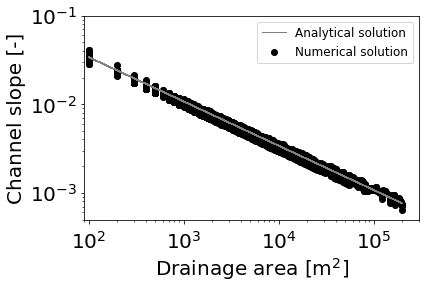

In [17]:
###MAKE SLOPE-AREA PLOT

import matplotlib

#assign area_array and slope_array
area_array = st.grid.at_node['drainage_area'][(st.grid.node_x > 10)&(st.grid.node_x < 1580)&(st.grid.node_y >10)&(st.grid.node_y<980)]
slope_array = st.grid.at_node['topographic__steepest_slope'][(st.grid.node_x > 10)&(st.grid.node_x < 1580)&(st.grid.node_y >10)&(st.grid.node_y<980)]

##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#plotting param
matplotlib.rcParams.update({'font.size': 20})

#create an array for the detachment-limited analytical solution
u = 0.0005 #m/yr, uplift or baselevel lowering rate
k = k_avg #fluvial erodibility
m = 0.5 #discharge exponent
n = 1.0 #slope exponent

#calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

#plot the analytical solution
slope_area.plot(area_array, analytical_slope_array, linestyle='-',
                color='grey', linewidth = 1, label = 'Analytical solution')

#plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Numerical solution') #plot HA data
                   
#make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(5e-4, 1e-1)

#set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

fig.savefig('stochastic_slope_area.eps',bbox_inches='tight', dpi=1000) #save figure

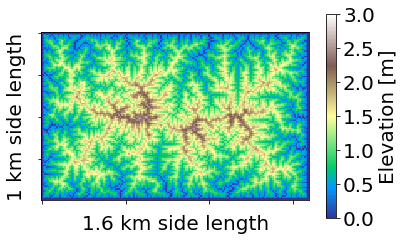

In [12]:
##MAKE TOPO FIGURE
#define 'topo'
topo = st.grid.at_node['topographic__elevation']
#plotting param
matplotlib.rcParams.update({'font.size': 20})

# #instantiate figure and plot
topo_fig = plt.figure(figsize=(6, 3.75))
t1 = plt.subplot()
topo = topo.reshape(100,160)
ts1_plot = t1.imshow(topo[::-1], cmap='terrain', vmin = 0, vmax = 3.0)

#add colorbar
cb = plt.colorbar(ts1_plot, label = 'Elevation [m]')

#axis labels
t1.tick_params(labelbottom='off', labelleft='off') 
t1.set_ylabel('1 km side length', labelpad = 15)
t1.set_xlabel('1.6 km side length', labelpad = 15)

#save figure
topo_fig.savefig('stochastic_topo.eps',bbox_inches='tight', dpi=300)